In [ ]:
!pip install --quiet pmdarima

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette('pastel')
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import os
import sys
from scipy import stats
from scipy.stats import gamma, kstest
from scipy.stats import anderson
#sys.stdout = open(os.devnull, 'w') #supress outputs

###Cargamos los datos:

In [ ]:
df = pd.read_csv('datosIMSS.csv')
df.set_index('Periodo', inplace=True)
desest = [int(s.replace(',', '')) for s in df.Desestacionalizados.values]
df.Desestacionalizados = desest
df.head()

,Desestacionalizados
Periodo,
1997/07,10228208
1997/08,10302942
1997/09,10402846
1997/10,10504875
1997/11,10571899


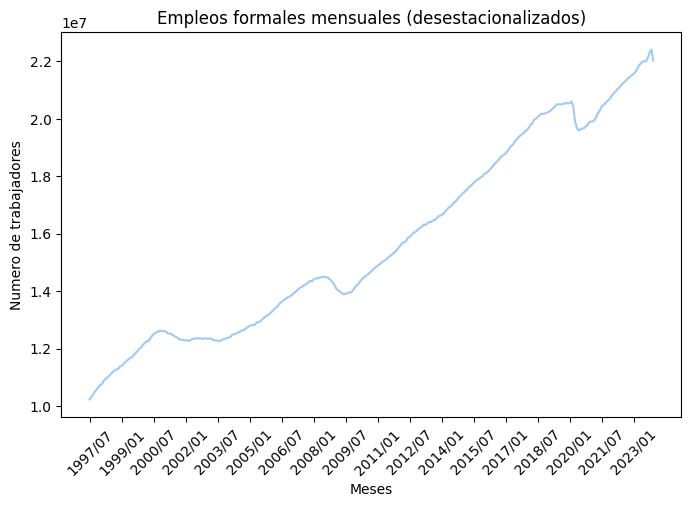

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('Empleos formales mensuales (desestacionalizados)')
plt.xlabel('Meses')
plt.ylabel('Numero de trabajadores')
plt.plot(df['Desestacionalizados'])
plt.xticks(df.index[::18], rotation=45)
plt.show()

###Funciones:

In [ ]:
def createSequences(data, sequenceLength, nAhead): #Crea secuencias de entrenamiento input y target para la red LSTM y GRU
  sequences = []
  targets = []
  for i in range(len(data) - sequenceLength - nAhead):
    sequences.append(data[i:i + sequenceLength])
    targets.append(data[i+sequenceLength:i+sequenceLength+nAhead])
  return np.array(sequences), np.array(targets)

In [ ]:
def createLaggedFeatures(data, lag): #para el xgboost
  for i in range(1, lag + 1):
    data[f'lag_{i}'] = data['target'].shift(-i)
  data.dropna(inplace=True)
  return data

In [ ]:
def predict(data, model, nAhead):
  '''
  data: es una serie de tiempo con las fechas como índice
  model: string del nombre del modelo, p.edf 'ARIMA'
  nModels: es el número de modelos/periodos de tiempo a evaluar.
  minTrainSize: es el tamaño mínimo del conjunto de entrenamiento que estamos dispuestos a aceptar
  nAhead: numero de puntos/meses a predecir
  '''
  #Escalamos los datos:
  scaler = MinMaxScaler()
  data1 = data.values
  data = scaler.fit_transform(data.values.reshape(-1 ,1)).flatten()

  if model == 'ARIMA':
      X = data1
  else:
      X = data

  if model == 'ARIMA':
    last = X[-1]
    X = np.diff(X)
    model = auto_arima(X)
    pred = model.predict(n_periods=nAhead, return_conf_int=False)
    pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))])
    return pred

  elif model=='HoltWinters':
    model = ExponentialSmoothing(X, seasonal='add', seasonal_periods=4, trend='add')
    model_fit = model.fit()
    pred = model_fit.forecast(steps=nAhead)
    pred = scaler.inverse_transform(pred.reshape(-1 ,1)).flatten()
    return pred

  elif model=='LSTM':
    sequenceLength = 20 #usará los últimos 36 meses para predecir 12, esto se puede ajustar
    last = X[-1] #guardamos el ultimo elemento para usarlo para convertir de la primera diferencia a la escala origianl despues
    X = np.diff(X) #obtenemos la primer diferencia
    X = X[:-sequenceLength].reshape(-1, 1)
    xTest = X[-sequenceLength:].reshape(-1, 1) #en vez de predict(nAhead), el modelo LSTM necesita un sequence de entrada para dar la prediction

    xTrain, yTrain = createSequences(X, sequenceLength, nAhead)

    #Creamos el modelo
    model = Sequential() #de mas a menos units por layer, numero de potencias de dos de units, subir el batch
    model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(sequenceLength, 1))) # return_sequences=True,
    model.add(LSTM(8, activation='relu', return_sequences=False)) #añadimos otra
    model.add(Dense(12))  #output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(xTrain, yTrain, epochs=10, verbose=0)

    #Predicción
    pred = model.predict(xTest.reshape(1, sequenceLength, 1)).flatten()
    pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1) #revertimos la primera diferencia
    pred = scaler.inverse_transform(pred).flatten()
    return pred

  elif model=='GRU': #preprocesamiento similar a las LSTM
    sequenceLength = 20
    last = X[-1]
    X = np.diff(X)
    X = X[:-sequenceLength].reshape(-1, 1)
    xTest = X[-sequenceLength:].reshape(-1, 1)

    xTrain, yTrain = createSequences(X, sequenceLength, nAhead)

    model = Sequential()
    model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(sequenceLength, 1)))
    model.add(LSTM(8, activation='relu', return_sequences=False))
    model.add(Dense(12))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(xTrain, yTrain, epochs=10, verbose=0)

    pred = model.predict(xTest.reshape(1, sequenceLength, 1)).flatten()
    pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1) #revertimos la primera diferencia
    pred = scaler.inverse_transform(pred).flatten()
    return pred

  elif model=='XGBoost':
    last = X[-1]
    X = np.diff(X)
    df = pd.DataFrame({'target': X})
    lags = 6
    data = createLaggedFeatures(df, lags)
    X = data.drop('target', axis=1).values
    y = data['target'].values
    model = xgb.XGBRegressor()
    model.fit(X, y)
    pred = []
    Xtest = np.append(X[-1, 1:], y[-1])
    for i in range(nAhead):
      pred.append(model.predict(Xtest.reshape(1, -1)))
      Xtest = np.append(Xtest[1:], pred[-1])
    pred = np.array([last+np.sum(pred[:i+1]) for i in range(len(pred))]).reshape(-1, 1)
    pred = scaler.inverse_transform(pred).flatten()
    return pred

###Predicciones:

In [ ]:
modelos = ['ARIMA', 'HoltWinters', 'LSTM', 'GRU', 'XGBoost']
nAhead = 12
preds = []
for modelo in modelos:
  preds.append(predict(df.Desestacionalizados, modelo, nAhead))

1/1 [==============================] - 0s 280ms/step


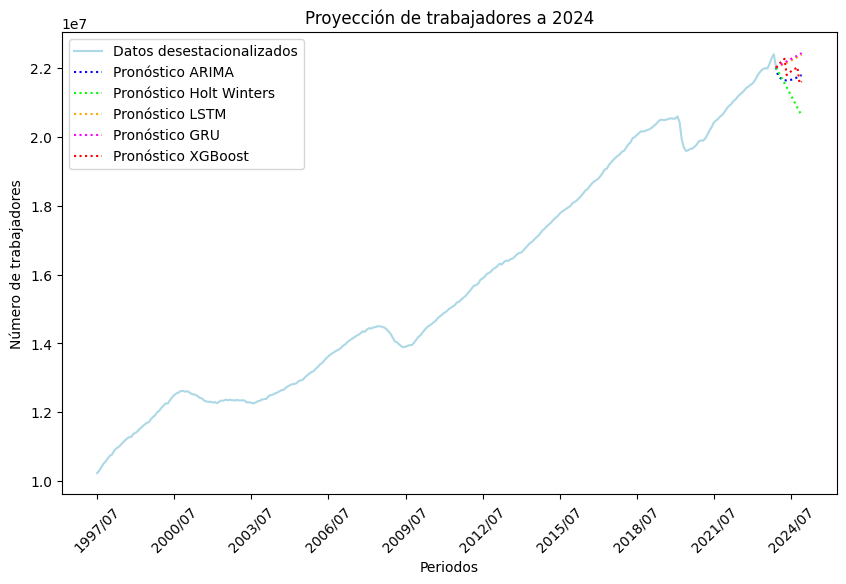

In [ ]:
X = df.Desestacionalizados.values
#X = df.Desestacionalizados.values[216:]
#X = df.Desestacionalizados.values[281:]
periodos = ['1997/07','1997/08','1997/09','1997/10','1997/11','1997/12','1998/01','1998/02','1998/03','1998/04','1998/05','1998/06','1998/07','1998/08','1998/09','1998/10','1998/11','1998/12','1999/01','1999/02','1999/03','1999/04','1999/05','1999/06','1999/07','1999/08','1999/09','1999/10','1999/11','1999/12','2000/01','2000/02','2000/03','2000/04','2000/05','2000/06','2000/07','2000/08','2000/09','2000/10','2000/11','2000/12','2001/01','2001/02','2001/03','2001/04','2001/05','2001/06','2001/07','2001/08','2001/09','2001/10','2001/11','2001/12','2002/01','2002/02','2002/03','2002/04','2002/05','2002/06','2002/07','2002/08','2002/09','2002/10','2002/11','2002/12','2003/01','2003/02','2003/03','2003/04','2003/05','2003/06','2003/07','2003/08','2003/09','2003/10','2003/11','2003/12','2004/01','2004/02','2004/03','2004/04','2004/05','2004/06','2004/07','2004/08','2004/09','2004/10','2004/11','2004/12','2005/01','2005/02','2005/03','2005/04','2005/05','2005/06','2005/07','2005/08','2005/09','2005/10','2005/11','2005/12','2006/01','2006/02','2006/03','2006/04','2006/05','2006/06','2006/07','2006/08','2006/09','2006/10','2006/11','2006/12','2007/01','2007/02','2007/03','2007/04','2007/05','2007/06','2007/07','2007/08','2007/09','2007/10','2007/11','2007/12','2008/01','2008/02','2008/03','2008/04','2008/05','2008/06','2008/07','2008/08','2008/09','2008/10','2008/11','2008/12','2009/01','2009/02','2009/03','2009/04','2009/05','2009/06','2009/07','2009/08','2009/09','2009/10','2009/11','2009/12','2010/01','2010/02','2010/03','2010/04','2010/05','2010/06','2010/07','2010/08','2010/09','2010/10','2010/11','2010/12','2011/01','2011/02','2011/03','2011/04','2011/05','2011/06','2011/07','2011/08','2011/09','2011/10','2011/11','2011/12','2012/01','2012/02','2012/03','2012/04','2012/05','2012/06','2012/07','2012/08','2012/09','2012/10','2012/11','2012/12','2013/01','2013/02','2013/03','2013/04','2013/05','2013/06','2013/07','2013/08','2013/09','2013/10','2013/11','2013/12','2014/01','2014/02','2014/03','2014/04','2014/05','2014/06','2014/07','2014/08','2014/09','2014/10','2014/11','2014/12','2015/01','2015/02','2015/03','2015/04','2015/05','2015/06','2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
#periodos = ['2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
#periodos = ['2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
df2 = pd.DataFrame({'periodos': periodos, 'x': list(X) + [np.nan]*nAhead, 'ARIMA': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[0]),
                   'HoltWinters': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[1]), 'LSTM': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[2]),
                   'GRU': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[3]), 'XGBoost': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[4])})

df2.set_index('periodos', inplace=True)
colores = ['lightblue', '#0000FF', '#00FF00', 'orange', '#FF00FF', '#FF0000']
ax = df2.plot(color=colores, figsize=(10, 6))
ax.lines[1].set_linestyle('dotted')
ax.lines[2].set_linestyle('dotted')
ax.lines[3].set_linestyle('dotted')
ax.lines[4].set_linestyle('dotted')
ax.lines[5].set_linestyle('dotted')

ax.lines[0].set_label('Datos desestacionalizados')
ax.lines[1].set_label('Pronóstico ARIMA')
ax.lines[2].set_label('Pronóstico Holt Winters')
ax.lines[3].set_label('Pronóstico LSTM')
ax.lines[4].set_label('Pronóstico GRU')
ax.lines[5].set_label('Pronóstico XGBoost')

ax.set_xlabel('Periodos')
ax.set_ylabel('Número de trabajadores')
ax.set_title('Proyección de trabajadores a 2024')
plt.xticks(rotation=45)
ax.legend()

tick_positions = np.arange(len(periodos))  # Positions for each tick
tick_labels = periodos[::36]  # Show every 6th month
plt.xticks(ticks=tick_positions[::36], labels=tick_labels, rotation=45)

plt.show()

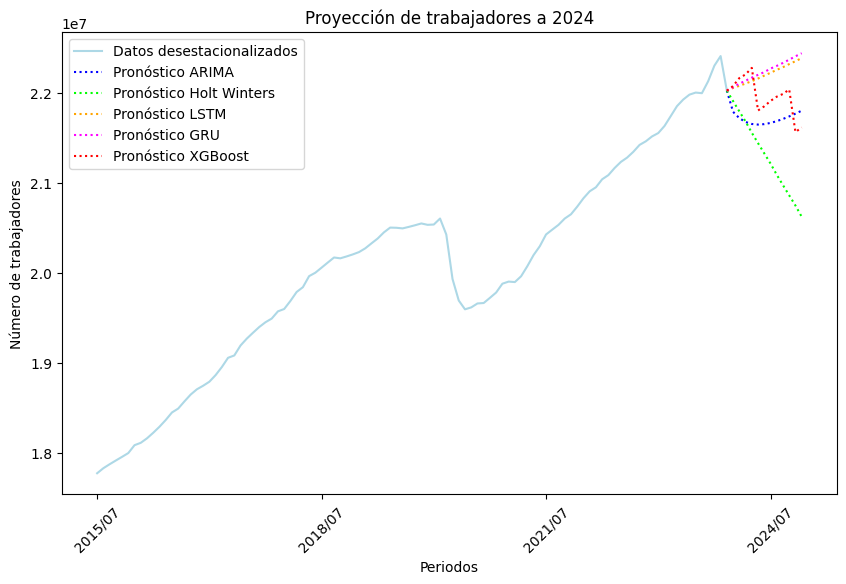

In [ ]:
#X = df.Desestacionalizados.values
X = df.Desestacionalizados.values[216:]
#X = df.Desestacionalizados.values[281:]
#periodos = ['1997/07','1997/08','1997/09','1997/10','1997/11','1997/12','1998/01','1998/02','1998/03','1998/04','1998/05','1998/06','1998/07','1998/08','1998/09','1998/10','1998/11','1998/12','1999/01','1999/02','1999/03','1999/04','1999/05','1999/06','1999/07','1999/08','1999/09','1999/10','1999/11','1999/12','2000/01','2000/02','2000/03','2000/04','2000/05','2000/06','2000/07','2000/08','2000/09','2000/10','2000/11','2000/12','2001/01','2001/02','2001/03','2001/04','2001/05','2001/06','2001/07','2001/08','2001/09','2001/10','2001/11','2001/12','2002/01','2002/02','2002/03','2002/04','2002/05','2002/06','2002/07','2002/08','2002/09','2002/10','2002/11','2002/12','2003/01','2003/02','2003/03','2003/04','2003/05','2003/06','2003/07','2003/08','2003/09','2003/10','2003/11','2003/12','2004/01','2004/02','2004/03','2004/04','2004/05','2004/06','2004/07','2004/08','2004/09','2004/10','2004/11','2004/12','2005/01','2005/02','2005/03','2005/04','2005/05','2005/06','2005/07','2005/08','2005/09','2005/10','2005/11','2005/12','2006/01','2006/02','2006/03','2006/04','2006/05','2006/06','2006/07','2006/08','2006/09','2006/10','2006/11','2006/12','2007/01','2007/02','2007/03','2007/04','2007/05','2007/06','2007/07','2007/08','2007/09','2007/10','2007/11','2007/12','2008/01','2008/02','2008/03','2008/04','2008/05','2008/06','2008/07','2008/08','2008/09','2008/10','2008/11','2008/12','2009/01','2009/02','2009/03','2009/04','2009/05','2009/06','2009/07','2009/08','2009/09','2009/10','2009/11','2009/12','2010/01','2010/02','2010/03','2010/04','2010/05','2010/06','2010/07','2010/08','2010/09','2010/10','2010/11','2010/12','2011/01','2011/02','2011/03','2011/04','2011/05','2011/06','2011/07','2011/08','2011/09','2011/10','2011/11','2011/12','2012/01','2012/02','2012/03','2012/04','2012/05','2012/06','2012/07','2012/08','2012/09','2012/10','2012/11','2012/12','2013/01','2013/02','2013/03','2013/04','2013/05','2013/06','2013/07','2013/08','2013/09','2013/10','2013/11','2013/12','2014/01','2014/02','2014/03','2014/04','2014/05','2014/06','2014/07','2014/08','2014/09','2014/10','2014/11','2014/12','2015/01','2015/02','2015/03','2015/04','2015/05','2015/06','2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
periodos = ['2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
#periodos = ['2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
df2 = pd.DataFrame({'periodos': periodos, 'x': list(X) + [np.nan]*nAhead, 'ARIMA': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[0]),
                   'HoltWinters': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[1]), 'LSTM': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[2]),
                   'GRU': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[3]), 'XGBoost': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[4])})

df2.set_index('periodos', inplace=True)
colores = ['lightblue', '#0000FF', '#00FF00', 'orange', '#FF00FF', '#FF0000']
ax = df2.plot(color=colores, figsize=(10, 6))
ax.lines[1].set_linestyle('dotted')
ax.lines[2].set_linestyle('dotted')
ax.lines[3].set_linestyle('dotted')
ax.lines[4].set_linestyle('dotted')
ax.lines[5].set_linestyle('dotted')

ax.lines[0].set_label('Datos desestacionalizados')
ax.lines[1].set_label('Pronóstico ARIMA')
ax.lines[2].set_label('Pronóstico Holt Winters')
ax.lines[3].set_label('Pronóstico LSTM')
ax.lines[4].set_label('Pronóstico GRU')
ax.lines[5].set_label('Pronóstico XGBoost')

ax.set_xlabel('Periodos')
ax.set_ylabel('Número de trabajadores')
ax.set_title('Proyección de trabajadores a 2024')
plt.xticks(rotation=45)
ax.legend()

tick_positions = np.arange(len(periodos))  # Positions for each tick
tick_labels = periodos[::36]  # Show every 6th month
plt.xticks(ticks=tick_positions[::36], labels=tick_labels, rotation=45)

plt.show()

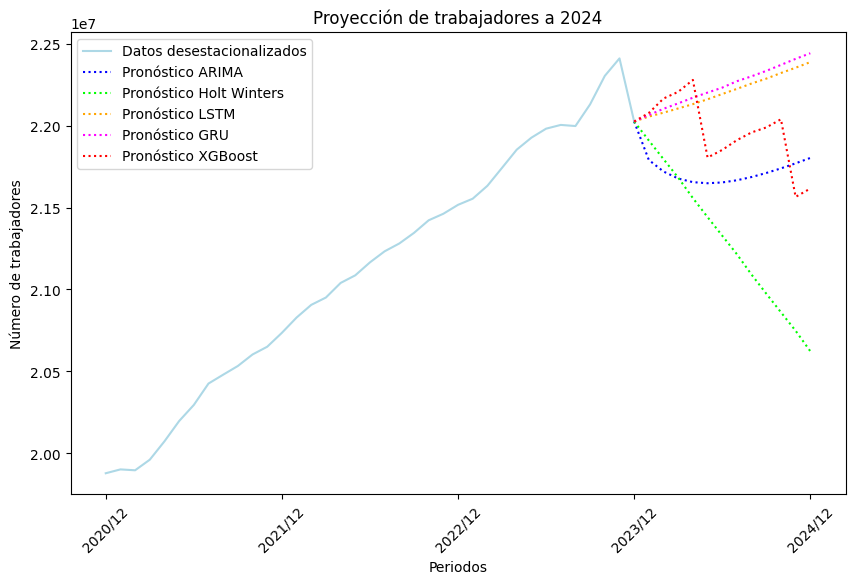

In [ ]:
#X = df.Desestacionalizados.values
#X = df.Desestacionalizados.values[216:]
X = df.Desestacionalizados.values[281:]
#periodos = ['1997/07','1997/08','1997/09','1997/10','1997/11','1997/12','1998/01','1998/02','1998/03','1998/04','1998/05','1998/06','1998/07','1998/08','1998/09','1998/10','1998/11','1998/12','1999/01','1999/02','1999/03','1999/04','1999/05','1999/06','1999/07','1999/08','1999/09','1999/10','1999/11','1999/12','2000/01','2000/02','2000/03','2000/04','2000/05','2000/06','2000/07','2000/08','2000/09','2000/10','2000/11','2000/12','2001/01','2001/02','2001/03','2001/04','2001/05','2001/06','2001/07','2001/08','2001/09','2001/10','2001/11','2001/12','2002/01','2002/02','2002/03','2002/04','2002/05','2002/06','2002/07','2002/08','2002/09','2002/10','2002/11','2002/12','2003/01','2003/02','2003/03','2003/04','2003/05','2003/06','2003/07','2003/08','2003/09','2003/10','2003/11','2003/12','2004/01','2004/02','2004/03','2004/04','2004/05','2004/06','2004/07','2004/08','2004/09','2004/10','2004/11','2004/12','2005/01','2005/02','2005/03','2005/04','2005/05','2005/06','2005/07','2005/08','2005/09','2005/10','2005/11','2005/12','2006/01','2006/02','2006/03','2006/04','2006/05','2006/06','2006/07','2006/08','2006/09','2006/10','2006/11','2006/12','2007/01','2007/02','2007/03','2007/04','2007/05','2007/06','2007/07','2007/08','2007/09','2007/10','2007/11','2007/12','2008/01','2008/02','2008/03','2008/04','2008/05','2008/06','2008/07','2008/08','2008/09','2008/10','2008/11','2008/12','2009/01','2009/02','2009/03','2009/04','2009/05','2009/06','2009/07','2009/08','2009/09','2009/10','2009/11','2009/12','2010/01','2010/02','2010/03','2010/04','2010/05','2010/06','2010/07','2010/08','2010/09','2010/10','2010/11','2010/12','2011/01','2011/02','2011/03','2011/04','2011/05','2011/06','2011/07','2011/08','2011/09','2011/10','2011/11','2011/12','2012/01','2012/02','2012/03','2012/04','2012/05','2012/06','2012/07','2012/08','2012/09','2012/10','2012/11','2012/12','2013/01','2013/02','2013/03','2013/04','2013/05','2013/06','2013/07','2013/08','2013/09','2013/10','2013/11','2013/12','2014/01','2014/02','2014/03','2014/04','2014/05','2014/06','2014/07','2014/08','2014/09','2014/10','2014/11','2014/12','2015/01','2015/02','2015/03','2015/04','2015/05','2015/06','2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
#periodos = ['2015/07','2015/08','2015/09','2015/10','2015/11','2015/12','2016/01','2016/02','2016/03','2016/04','2016/05','2016/06','2016/07','2016/08','2016/09','2016/10','2016/11','2016/12','2017/01','2017/02','2017/03','2017/04','2017/05','2017/06','2017/07','2017/08','2017/09','2017/10','2017/11','2017/12','2018/01','2018/02','2018/03','2018/04','2018/05','2018/06','2018/07','2018/08','2018/09','2018/10','2018/11','2018/12','2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12','2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
periodos = ['2020/12','2021/01','2021/02','2021/03','2021/04','2021/05','2021/06','2021/07','2021/08','2021/09','2021/10','2021/11','2021/12','2022/01','2022/02','2022/03','2022/04','2022/05','2022/06','2022/07','2022/08','2022/09','2022/10','2022/11','2022/12','2023/01','2023/02','2023/03','2023/04','2023/05','2023/06','2023/07', '2023/08', '2023/09', '2023/10', '2023/11', '2023/12', '2024/01', '2024/02', '2024/03', '2024/04', '2024/05', '2024/06', '2024/07', '2024/08', '2024/09', '2024/10', '2024/11', '2024/12']
df2 = pd.DataFrame({'periodos': periodos, 'x': list(X) + [np.nan]*nAhead, 'ARIMA': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[0]),
                   'HoltWinters': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[1]), 'LSTM': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[2]),
                   'GRU': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[3]), 'XGBoost': [np.nan]*(len(X)-1) + [X[-1]] + list(preds[4])})

df2.set_index('periodos', inplace=True)
colores = ['lightblue', '#0000FF', '#00FF00', 'orange', '#FF00FF', '#FF0000']
ax = df2.plot(color=colores, figsize=(10, 6))
ax.lines[1].set_linestyle('dotted')
ax.lines[2].set_linestyle('dotted')
ax.lines[3].set_linestyle('dotted')
ax.lines[4].set_linestyle('dotted')
ax.lines[5].set_linestyle('dotted')

ax.lines[0].set_label('Datos desestacionalizados')
ax.lines[1].set_label('Pronóstico ARIMA')
ax.lines[2].set_label('Pronóstico Holt Winters')
ax.lines[3].set_label('Pronóstico LSTM')
ax.lines[4].set_label('Pronóstico GRU')
ax.lines[5].set_label('Pronóstico XGBoost')

ax.set_xlabel('Periodos')
ax.set_ylabel('Número de trabajadores')
ax.set_title('Proyección de trabajadores a 2024')
plt.xticks(rotation=45)
ax.legend()

tick_positions = np.arange(len(periodos))  # Positions for each tick
tick_labels = periodos[::12]  # Show every 6th month
plt.xticks(ticks=tick_positions[::12], labels=tick_labels, rotation=45)

plt.show()

In [ ]:
preds = np.array(preds)
preds.shape

(5, 12)

In [ ]:
preds

array([[21789685.08817347, 21719445.30833619, 21676779.39114587,
        21654706.84096409, 21648014.31824449, 21652808.27292506,
        21666180.83147284, 21685960.26671106, 21710524.63776891,
        21738662.60824253, 21769469.49910836, 21802269.656491  ],
       [21908565.88517441, 21794931.03228445, 21682117.83856842,
        21557416.10950571, 21441614.9873983 , 21327980.13450835,
        21215166.94079232, 21090465.21172961, 20974664.0896222 ,
        20861029.23673225, 20748216.04301621, 20623514.3139535 ],
       [22054575.10008545, 22078398.60293107, 22104184.40620077,
        22130318.4772459 , 22159979.08425635, 22192125.29241332,
        22223660.23100856, 22256289.80974358, 22285915.20312575,
        22320264.07818645, 22352496.23300835, 22386768.03287879],
       [22063938.93874605, 22102111.8050987 , 22135144.11701812,
        22169649.89919639, 22200871.65885392, 22231057.45262602,
        22270266.12603974, 22300157.43676957, 22333277.66931376,
        22369659.22384